In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import os

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.agents.dca_agent import DCAAgent
from agentfil import constants
from mechafil import minting, sim

import numpyro

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

#simulation_start_date = datetime.today().date() - timedelta(days=5)
simulation_start_date = date(2023,6,1)
forecast_length = 10*365
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 1
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.35)

auth_token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

print('Simulation Start:', simulation_start_date)

Simulation Start: 2023-06-01


In [4]:
data.setup_spacescope(auth_token)

In [5]:
historical_stats = data.get_historical_network_stats(
    constants.NETWORK_DATA_START,
    simulation_start_date,
    end_date
)

In [6]:
historical_stats.columns

Index(['circulating_fil', 'mined_fil', 'vested_fil', 'locked_fil', 'burnt_fil',
       'reserve_disbursed_fil', 'date', 'total_raw_power_eib',
       'total_qa_power_eib', 'day_onboarded_rb_power_pib',
       'day_onboarded_qa_power_pib', 'rb_renewal_rate',
       'day_renewed_qa_power_pib'],
      dtype='object')

In [7]:
agent_types = [DCAAgent] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 6  # 6 PiB/day of RBP
renewal_rate = 0.8
fil_plus_rate = 0.8
for ii in range(num_agents):
    kwargs = {
        'max_daily_rb_onboard_pib': mean_pow,
        'renewal_rate': renewal_rate,
        'fil_plus_rate': fil_plus_rate,
        'sector_duration': 360
    }
    agent_kwargs_vec.append(kwargs)

rewards_per_sector_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 20000,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': False,
    'keep_power_predictions': False,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               spacescope_cfg=auth_token,
                               agent_types=agent_types, agent_kwargs_list=agent_kwargs_vec, 
                               agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=True,
                               price_process_kwargs=price_process_kwargs,
                               rewards_per_sector_process_kwargs=rewards_per_sector_process_kwargs,
                               renewals_setting='optimistic',
                              )

/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[
/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]


seeding agent 0 with power pct 1.0
Fast forwarding power to simulation start date... 2023-06-01
Computing Scheduled Expirations from:  2023-06-01  to:  2024-11-28
Initializing circulating supply...
Updating circulating supply statistics...
Updating circulating supply statistics... --> start_date: 2021-03-16
Finished updating CS.  Final date -> 2023-05-31


/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[


In [8]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/3650 [00:00<?, ?it/s]

In [9]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_97835/1742197849.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]


In [10]:
# run mechafil
rbp = mean_pow
rr = renewal_rate
fpr = fil_plus_rate

mechafil_start_date = constants.NETWORK_DATA_START
mechafil_current_date = simulation_start_date
mechafil_forecast_length = forecast_length

# compute mechaFIL predictions to compare with agentFIL to better determine
# if implementation/porting of code is correct
mechafil_df = sim.run_simple_sim(
    mechafil_start_date,
    mechafil_current_date,
    mechafil_forecast_length,
    rr,
    rbp,
    fpr,
    360,
    auth_token,
    qap_method = 'basic' # can be set to tunable or basic
                         # see: https://hackmd.io/O6HmAb--SgmxkjLWSpbN_A?view
)

/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:153: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  init_baseline_bytes = bp_df[bp_df["date"] >= pd.to_datetime(date, utc="UTC")].iloc[
/Users/kiran/code/agentfil_mechafil_install/filecoin-mecha-twin/mechafil/data.py:170: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_df = df[df["date"] >= pd.to_datetime(date, utc="UTC")]


In [11]:
# agent plotting helper functions
def plot_agent(keys, post_process=None, agent_idxs_to_plot=None, df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if post_process is None:
        post_fn = lambda x: x
    else:
        post_fn = post_process
    
    # defaults to plotting all agents
    for ii, agent_dict in enumerate(filecoin_model.agents):
        if agent_idxs_to_plot is None or ii in agent_idxs_to_plot:
            agent_handle = agent_dict['agent']
            agent_df = getattr(agent_handle, df_name)
            l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                y = post_fn(agent_df[k])
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                y = post_fn(key_data)
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            plt.xticks(rotation=60)

0.37258212566375803 0.14998629448672318


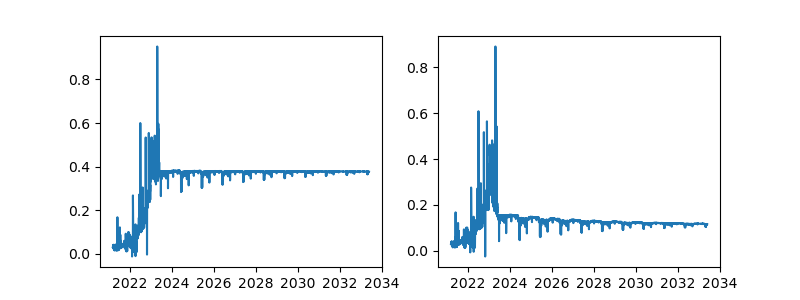

In [12]:
EIB=2**60
plt.figure(figsize=(8,3))
ix = model_df[model_df['date']==simulation_start_date].index

plt.subplot(1,2,1)
plt.plot(model_df['date'], (model_df['total_raw_power_eib'] - mechafil_df['network_RBP']/EIB))
plt.subplot(1,2,2)
plt.plot(model_df['date'], (model_df['total_qa_power_eib'] - mechafil_df['network_QAP']/EIB))

rb_power_offset = (model_df.iloc[ix]['total_raw_power_eib'] - mechafil_df.iloc[ix]['network_RBP']/EIB).values[0]
qa_power_offset = (model_df.iloc[ix]['total_qa_power_eib'] - mechafil_df.iloc[ix]['network_QAP']/EIB).values[0]
print(rb_power_offset, qa_power_offset)

In [13]:
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880
duration = 360

def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

mechafil_df = add_generated_quantities(mechafil_df)

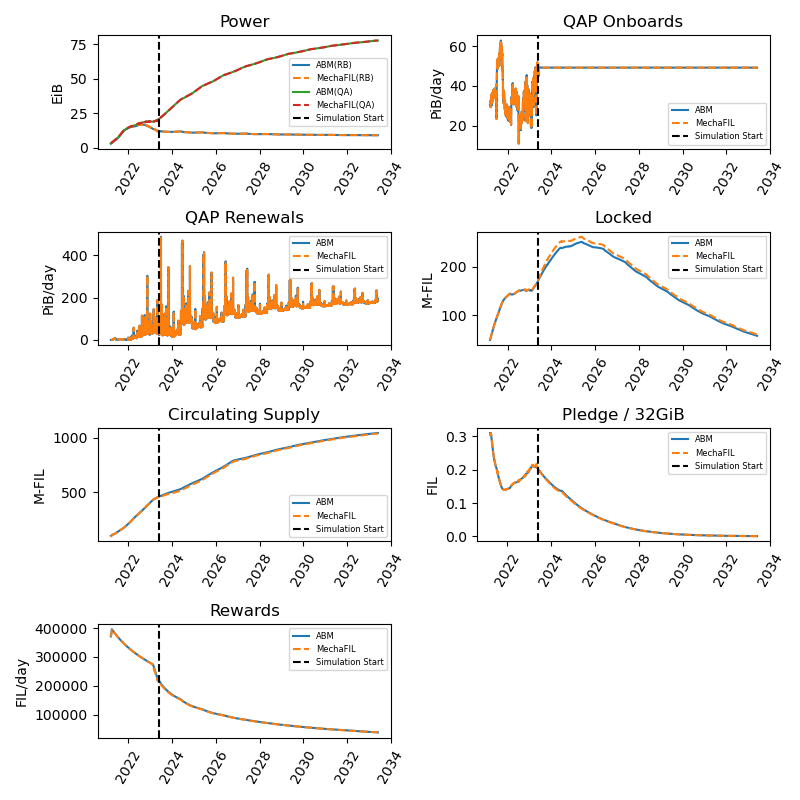

In [14]:

plt.figure(figsize=(8,8))
plt.subplot(4,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib']-rb_power_offset, label='ABM(RB)')
plt.plot(mechafil_df['date'], mechafil_df['network_RBP']/EIB, label='MechaFIL(RB)', linestyle='--')
plt.plot(model_df['date'], model_df['total_qa_power_eib']-qa_power_offset, label='ABM(QA)')
plt.plot(mechafil_df['date'], mechafil_df['network_QAP']/EIB, label='MechaFIL(QA)', linestyle='--')
# plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(4,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='ABM')
plt.plot(mechafil_df['date'], mechafil_df['day_onboarded_power_QAP']/PIB, linestyle='--', label='MechaFIL')
# plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'] - mechafil_df['day_onboarded_power_QAP']/PIB, 
#          label='Onboarded[ABM-MechaFIL]')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QAP Onboards')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,3)
plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='ABM')
plt.plot(mechafil_df['date'], mechafil_df['day_renewed_power_QAP']/PIB, linestyle='--', label='MechaFIL')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QAP Renewals')
plt.ylabel('PiB/day')
plt.legend(fontsize=6)

plt.subplot(4,2,4)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000, label='ABM')
plt.plot(mechafil_df['date'], mechafil_df['network_locked']/1_000_000, linestyle='--', label='MechaFIL')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')
plt.legend(fontsize=6)

plt.subplot(4,2,5)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000, label='ABM')
plt.plot(mechafil_df['date'], mechafil_df['circ_supply']/1_000_000, linestyle='--', label='MechaFIL')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.legend(fontsize=6)

plt.subplot(4,2,6)
plt.plot(model_df['date'].iloc[1:], model_df['day_pledge_per_QAP'].iloc[1:], label='ABM')
plt.plot(model_df['date'].iloc[1:], mechafil_df['day_pledge_per_QAP'].iloc[1:], linestyle='--', label='MechaFIL')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')
plt.legend(fontsize=6)

plt.subplot(4,2,7)
plt.plot(model_df['date'], model_df['day_network_reward'], label='ABM')
plt.plot(mechafil_df['date'], mechafil_df['day_network_reward'], linestyle='--', label='MechaFIL')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')
plt.legend(fontsize=6)

plt.tight_layout()

plt.show()
plt.savefig(os.path.join(os.environ['HOME'], 'Documents', 'hackmd', 'abm', 'NO_renew_deal_sectors.png'))